# Week 3 assignment

## Exploring, segmenting, and clustering the neighborhoods in the city of Toronto

### PART 3: Exploring and clustering the data

In [1]:
import pandas as pd
import numpy as np

I import the data obtained in part 2

In [2]:
df=pd.read_csv("final_data.csv")

In [3]:
df.head()

,Unnamed: 0,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


I drop the column Unnamed: 0

In [4]:
df=df[["Postcode","Borough","Neighbourhood","Latitude","Longitude"]]
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Let's display the neighbourhoods on a map

In [5]:
import folium
from geopy.geocoders import Nominatim
import json
from pandas.io.json import json_normalize
import requests
import geocoder

In [6]:
geolocator=Nominatim(user_agent="foursquare_agent")

In [7]:
# getting the coordinates of Toronto
address="Toronto, ON, Canada"
coord=geolocator.geocode(address)
latitude=coord.latitude
longitude=coord.longitude

In [9]:
tor_map=folium.Map(location=[latitude,longitude],zoom_start=10)
for label, lat, long in zip(df.Neighbourhood, df.Latitude, df.Longitude):
    folium.CircleMarker([lat,long],
                        radius=5,
                        color="blue",
                       fill=True,
                       popup=label,
                       fill_color="blue",
                       fill_opacity=0.3).add_to(tor_map)
tor_map

I want to collect information about venues in these neighbourhoods.

In [10]:
CLIENT_ID="NX2JDTQDT0ZX1W4BPFX3PESC5Q22BGIKVCWHIRP1Y01XTV3V"
CLIENT_SECRET='ULXPLSTP0DCLEXE1GFCNUGDWRHOPHLQQ5XIFGJSHFZNC4C4Z'
VERSION='20180604'
radius=500
limit=30

In [11]:
#This is the function to get the venue categories
def getvenues(neighs,latitudes, longitudines, radius):
    venues=[]
    for n,lat,long in zip(neighs,latitudes,longitudines):
        print(n)
        url="https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,limit)
        results=requests.get(url).json()["response"]['groups'][0]['items']
        venues.append([(n,lat,long,v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    neigh_venues=pd.DataFrame([item for venue_list in venues for item in venue_list])
    neigh_venues.columns=['Neighborhood', 
                'Neighborhood Latitude', 
                'Neighborhood Longitude', 
                'Venue', 
                 'Venue Latitude', 
                 'Venue Longitude', 
                 'Venue Category']
    return neigh_venues

In [12]:
df_venues=getvenues(df.Neighbourhood,df.Latitude,df.Longitude,radius)

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

Let's ceck the df_venues dataframe:

In [13]:
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [14]:
df_venues.shape

(1314, 7)

In [16]:
print("There are {} different venue categories in the dataframe".format(len(df_venues["Venue Category"].unique())))

There are 238 different venue categories in the dataframe


Now I want to cluster the data by using KMeans. I import the package

In [17]:
from sklearn.cluster import KMeans

I create a dataframe df_oh_venues with one hot encoded venues

In [19]:
df_oh_venues=pd.get_dummies(df_venues[['Venue Category']],prefix="",prefix_sep="")
df_oh_venues.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_oh_venues=df_oh_venues.drop("Neighborhood",axis=1)
categories=list(df_oh_venues.columns)

In [21]:
#adding the Neighborhood names
df_oh_venues["Neighborhood"]=df_venues["Neighborhood"]

In [22]:
df_oh_venues=df_oh_venues[["Neighborhood"]+categories]

In [23]:
df_oh_venues.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I group the dataframe by Neighborhood and calculate the mean frequency of each venue category

In [25]:
df_oh_venues_grouped=df_oh_venues.groupby("Neighborhood").mean()
df_oh_venues_grouped.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,...,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0
"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I print the 5 most common venues in each neighborhood

In [26]:
for n in df_oh_venues_grouped.index:
    print(n)
    print(df_oh_venues_grouped.loc[n].sort_values(ascending=False).head(5))
               

Adelaide, King, Richmond
Steakhouse          0.100000
Hotel               0.066667
Asian Restaurant    0.066667
Coffee Shop         0.066667
Café                0.066667
Name: Adelaide, King, Richmond, dtype: float64
Agincourt
Lounge                0.2
Breakfast Spot        0.2
Skating Rink          0.2
Chinese Restaurant    0.2
Sandwich Place        0.2
Name: Agincourt, dtype: float64
Agincourt North, L'Amoreaux East, Milliken, Steeles East
Park                    0.5
Playground              0.5
Yoga Studio             0.0
Deli / Bodega           0.0
Ethiopian Restaurant    0.0
Name: Agincourt North, L'Amoreaux East, Milliken, Steeles East, dtype: float64
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown
Grocery Store          0.2
Video Store            0.1
Fried Chicken Joint    0.1
Sandwich Place         0.1
Beer Store             0.1
Name: Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, S

By using KMeans I want to find the best value of number of clusters, that I will choose by looking at the average distance of points respect to centroid in each cluster and taking the ellbow point (where the curve changes its derivative).
First I calculate this distance for each value of k in a range between 1 and 20:

In [27]:
ks=list(range(1,20))
err=[]
for k in ks:
    km=KMeans(n_clusters=k,init="k-means++",n_init=12,random_state=0)
    km.fit(df_oh_venues_grouped[categories])
    labels=km.labels_
    centroids=km.cluster_centers_
    df_oh_venues_grouped["Cluster"]=labels
    errore=0
    for n in range(k):
        errore+=((centroids[n]-df_oh_venues_grouped[df_oh_venues_grouped["Cluster"]==n][categories])**2).sum(axis=0).sum()
    errore=np.sqrt(errore)/k
    err.append(errore)

Let's plot the average distance between points and their centroids as a function of k

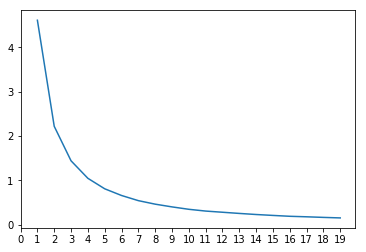

In [29]:
import matplotlib.pyplot as plt
plt.plot(np.array(ks),np.array(err))
plt.xticks(np.arange(0,20,1))
plt.show()

In order to find the ellbow point I download and import the package kneed

In [30]:
!conda install -c conda-forge kneed --yes

Solving environment: ...working... done

# All requested packages already installed.



In [31]:
from kneed import KneeLocator
kn = KneeLocator(np.array(ks), np.array(err), curve='convex', direction='decreasing')
print(kn.knee)

4


The ellbow point is at kstar=4. I make the final cluster with this value of k

In [32]:
kstar=4
km=KMeans(n_clusters=kstar,init="k-means++",n_init=12,random_state=0)
km.fit(df_oh_venues_grouped[categories])
labels=km.labels_

I add the column with cluster numbers to the dataframe

In [33]:
df_oh_venues_grouped["Cluster"]=labels

In [34]:
df_oh_venues_grouped=df_oh_venues_grouped.reset_index()[["Cluster","Neighborhood"]+categories]
df_oh_venues_grouped.head()


,Cluster,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,2,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,...,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0
4,2,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I find the most common venues and create a new dataframe df_venues_sorted

In [36]:
#function from the lab to take the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ["Cluster",'Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['Neighborhood'] = df_oh_venues_grouped['Neighborhood']
df_venues_sorted['Cluster'] = df_oh_venues_grouped['Cluster']

for ind in np.arange(df_oh_venues_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 2:] = return_most_common_venues(df_oh_venues_grouped.iloc[ind, 2:], num_top_venues)

df_venues_sorted.head()

,Cluster,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,"Adelaide, King, Richmond",Steakhouse,Asian Restaurant,Hotel,Pizza Place,Café,Coffee Shop,Lounge,Plaza,Bar,Sushi Restaurant
1,2,Agincourt,Lounge,Breakfast Spot,Skating Rink,Chinese Restaurant,Sandwich Place,Yoga Studio,Dim Sum Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
2,0,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
3,2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Coffee Shop,Video Store,Sandwich Place,Pizza Place,Beer Store,Pharmacy,Fast Food Restaurant,Fried Chicken Joint,Eastern European Restaurant
4,2,"Alderwood, Long Branch",Pizza Place,Pub,Sandwich Place,Coffee Shop,Skating Rink,Gym,Pharmacy,Athletics & Sports,Pool,Dessert Shop


Now I merge this dataframe with the initial one, containing other information such as the coordinates

In [38]:
df_clustered=pd.merge(df_venues_sorted,df,how="inner",left_on="Neighborhood",right_on="Neighbourhood").drop("Neighbourhood",axis=1)
df_clustered.head()

,Cluster,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
0,2,"Adelaide, King, Richmond",Steakhouse,Asian Restaurant,Hotel,Pizza Place,Café,Coffee Shop,Lounge,Plaza,Bar,Sushi Restaurant,M5H,Downtown Toronto,43.650571,-79.384568
1,2,Agincourt,Lounge,Breakfast Spot,Skating Rink,Chinese Restaurant,Sandwich Place,Yoga Studio,Dim Sum Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,M1S,Scarborough,43.794200,-79.262029
2,0,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,M1V,Scarborough,43.815252,-79.284577
3,2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Coffee Shop,Video Store,Sandwich Place,Pizza Place,Beer Store,Pharmacy,Fast Food Restaurant,Fried Chicken Joint,Eastern European Restaurant,M9V,Etobicoke,43.739416,-79.588437
4,2,"Alderwood, Long Branch",Pizza Place,Pub,Sandwich Place,Coffee Shop,Skating Rink,Gym,Pharmacy,Athletics & Sports,Pool,Dessert Shop,M8W,Etobicoke,43.602414,-79.543484


I want to have a look at the num_col (defined below) most common categories in each cluster.

In [41]:
num_col=3
for n in range(kstar):
    print("Cluster {}".format(n))
    print(df_clustered[df_clustered["Cluster"]==n]["Neighborhood"].count())
    #print(df_clustered[df_clustered["Cluster"]==n][["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"]].head(5))
for n in range(kstar):
    print("Cluster {}".format(n))
    cat=[]
    for i in range(2,2+num_col):
        cat.extend(df_clustered[df_clustered["Cluster"]==n][df_clustered.columns[i]].unique())
    print(set(sorted(cat)))

Cluster 0
12
Cluster 1
5
Cluster 2
81
Cluster 3
2
Cluster 0
{"Women's Store", 'Other Repair Shop', 'Grocery Store', 'Market', 'River', 'Airport', 'Playground', 'Mobile Phone Shop', 'Park', 'Shopping Mall', 'Swim School', 'Construction & Landscaping', 'Convenience Store', 'Pub', 'Coffee Shop', 'Bus Line', 'Bakery', 'Department Store', 'Pizza Place', 'Basketball Court', 'Bank', 'Building', 'Yoga Studio'}
Cluster 1
{'Food & Drink Shop', 'Golf Course', 'Mediterranean Restaurant', 'Restaurant', 'Fast Food Restaurant', 'Park', 'Pool', 'Sandwich Place', 'Yoga Studio', 'Dessert Shop', 'Baseball Field'}
Cluster 2
{'Drugstore', 'Café', 'Bookstore', 'Deli / Bodega', 'Field', 'Vietnamese Restaurant', 'Motel', 'Fast Food Restaurant', 'Soccer Field', 'Furniture / Home Store', 'Airport Terminal', 'Vegetarian / Vegan Restaurant', 'Hockey Arena', 'Ice Cream Shop', 'Liquor Store', 'Butcher', 'Coffee Shop', 'Baseball Field', 'Pharmacy', 'Auto Garage', 'Chinese Restaurant', 'Greek Restaurant', 'Skating Ri

By looking at the first most common venues (num_col=1), first and second most common venues (num_col=2), 1st, 2nd and 3rd most common venues (num_col=3) I honestly cannot find a clear criteria to differentiate/cluster the venues

I can display these information on a map. The colors and size of the points depend on the cluster number

In [42]:
tor_map_clustered=folium.Map(location=[latitude,longitude],zoom_start=10)
colors=["blue","red","orange","green"]

for n,c,lat,long in zip(df_clustered.Neighborhood,df_clustered.Cluster,df_clustered.Latitude,df_clustered.Longitude):
    folium.CircleMarker([lat,long],
                        radius=c+3,
                       popup=n,
                       color=colors[c],
                       fill=True,
                       fill_color=colors[c],
                       fill_opacity=0.4).add_to(tor_map_clustered)

tor_map_clustered